# This script demonstrates how to train a M²VAE with a split MNIST data set and evaluate the Hyperparameter

In [120]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.loader
from vae_tools.mmvae import MmVae, ReconstructionLoss
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import glob
import pickle

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


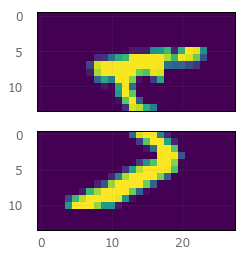

In [121]:


# Get the split MNIST digits
(x_train_a, x_train_b), (x_test_a, x_test_b), y_train, y_test = vae_tools.loader.mnist_split(flatten = True, split = 'hor')

# Show a split image

img_rows, img_cols = 28, 28

f, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
plt.show()


In [122]:
import astetik
%matplotlib inline

In [123]:
h_prefix = 'h_'

#dump_loc_prefix = '/mnt/ssd_pcie/mmvae_mnist_split_3/' # shared weights
dump_loc_prefix = '/mnt/ssd_pcie/mmvae_mnist_split_4/' # non-shared weights

def load_dfs(dump_loc):
    # get the history
    df = pd.read_hdf(dump_loc + 'history.h5', key='df', mode='r+')

    # Load the JSD and average it over all samples
    prefix = 'jsd_'
    jsd = None
    for idx in df['index']:
        loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
        data = pickle.load( open( loc, "rb" ) )
        if jsd is None:
            jsd = {}
            for k in data.keys():
                jsd[prefix + k] = []
        for k in data.keys():
            #print(np.mean(js[k]))
            jsd[prefix + k].append(np.mean(data[k]))
    # Add the JSD to the pandas data frame
    df_jsd = pd.DataFrame(jsd, columns=jsd.keys())

    # Load the GNB classifications and calculate the precision

    gnb = None
    prefix = 'gnb_prec_'
    denom = len(y_test)
    for idx in df['index']:
        loc = dump_loc + 'bayes_classifier_' + str(idx) + '.p'
        data = pickle.load( open( loc, "rb" ) )
        if gnb is None:
            gnb = {}
            for k in data.keys():
                gnb[prefix + k] = []
        for k in data.keys():
            #print(np.mean(js[k]))
            gnb[prefix + k].append(np.sum((data[k] == y_test))/denom)
    # Add the JSD to the pandas data frame
    df_gnb = pd.DataFrame(gnb, columns=gnb.keys())

    return df, df_jsd, df_gnb

df_lst, df_jsd_lst, df_gnb_lst = [], [], []

for seed in range(5):
    dump_loc = dump_loc_prefix + str(seed) + "/"
    df, df_jsd, df_gnb = load_dfs(dump_loc)
    df_lst.append(df)
    df_jsd_lst.append(df_jsd)
    df_gnb_lst.append(df_gnb)

df = pd.concat(df_lst, axis =0)
df_jsd = pd.concat(df_jsd_lst, axis =0)
df_gnb = pd.concat(df_gnb_lst, axis =0)


## Show the correlation matrix

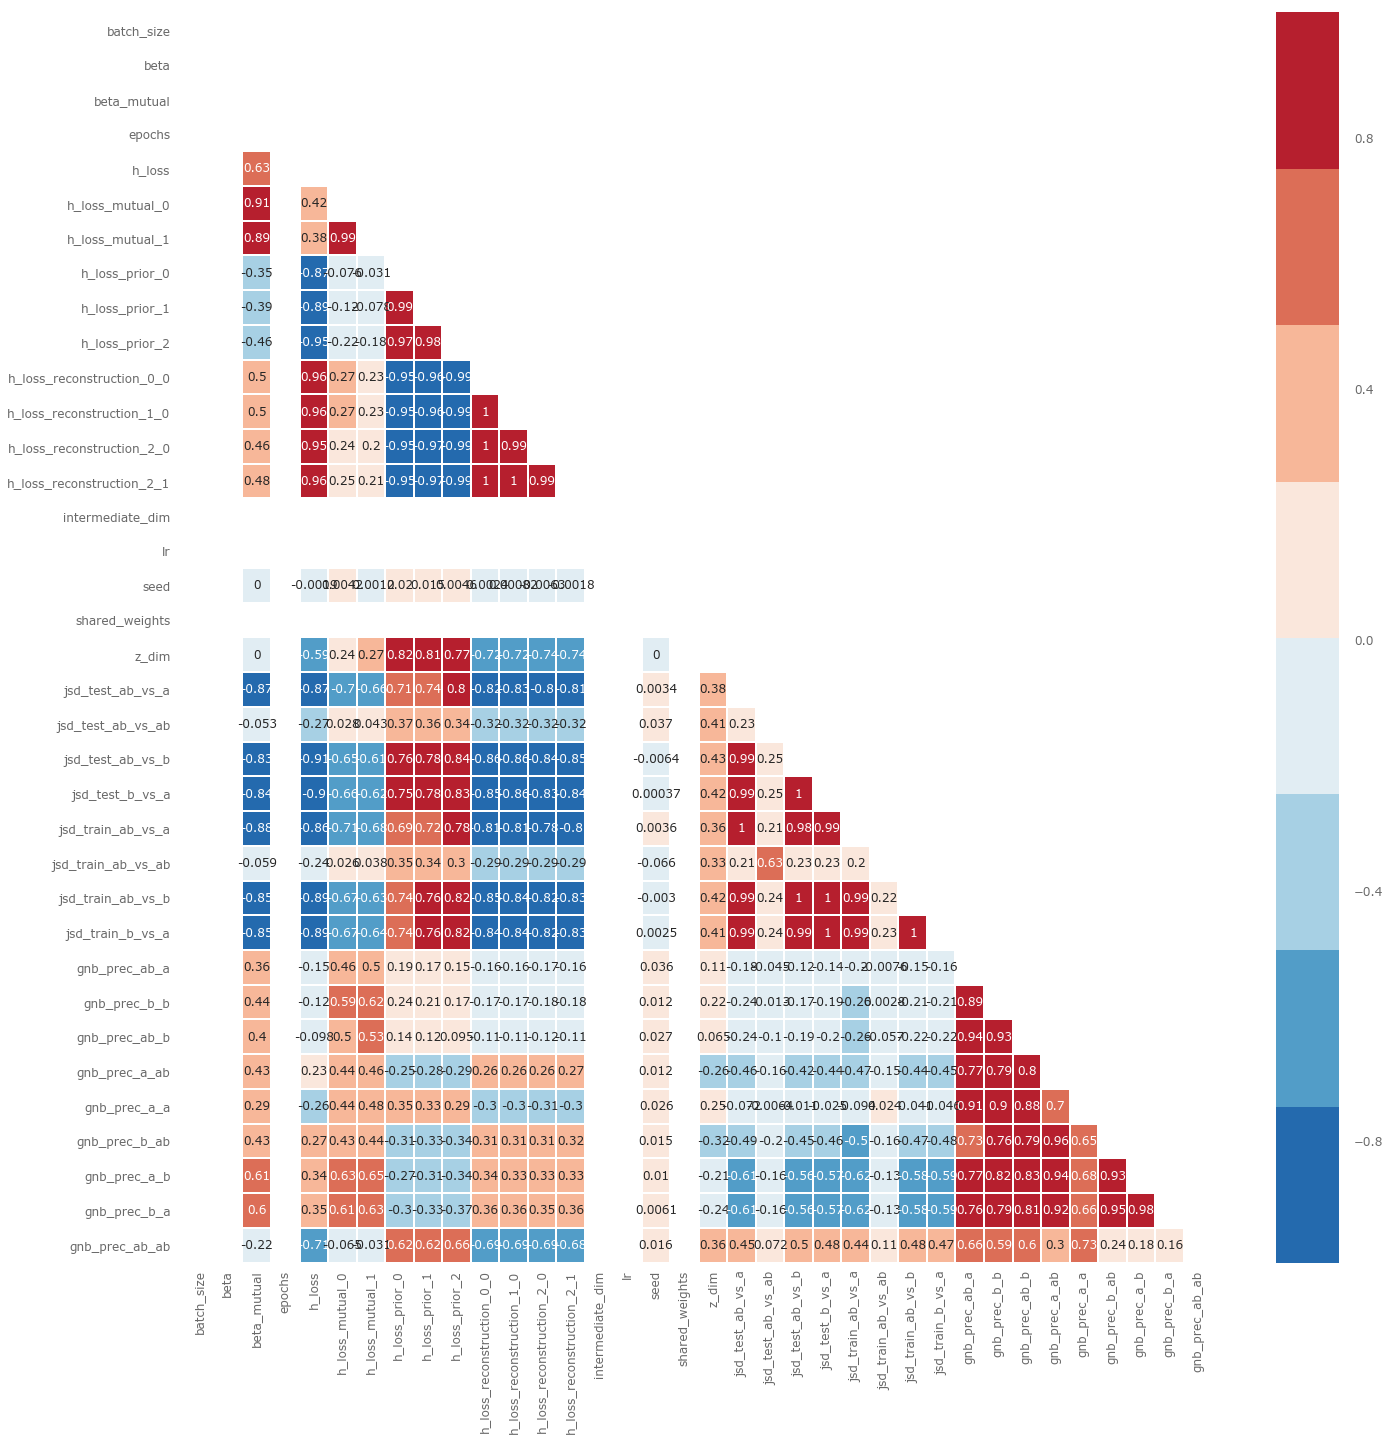

In [124]:
# concat
_df = pd.concat([df, df_jsd, df_gnb], axis =1) # .reset_index()


# make beta-mutual linear
#_df['beta_mutual'] = _df['beta_mutual'].apply(lambda x: int(np.log10(x)))
#_df = _df[_df['beta_mutual'] != int(1)]

# correlation w/o validation
_df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]


astetik.corr(_df, color_grades=5, style='astetik', annot=True)
#_df

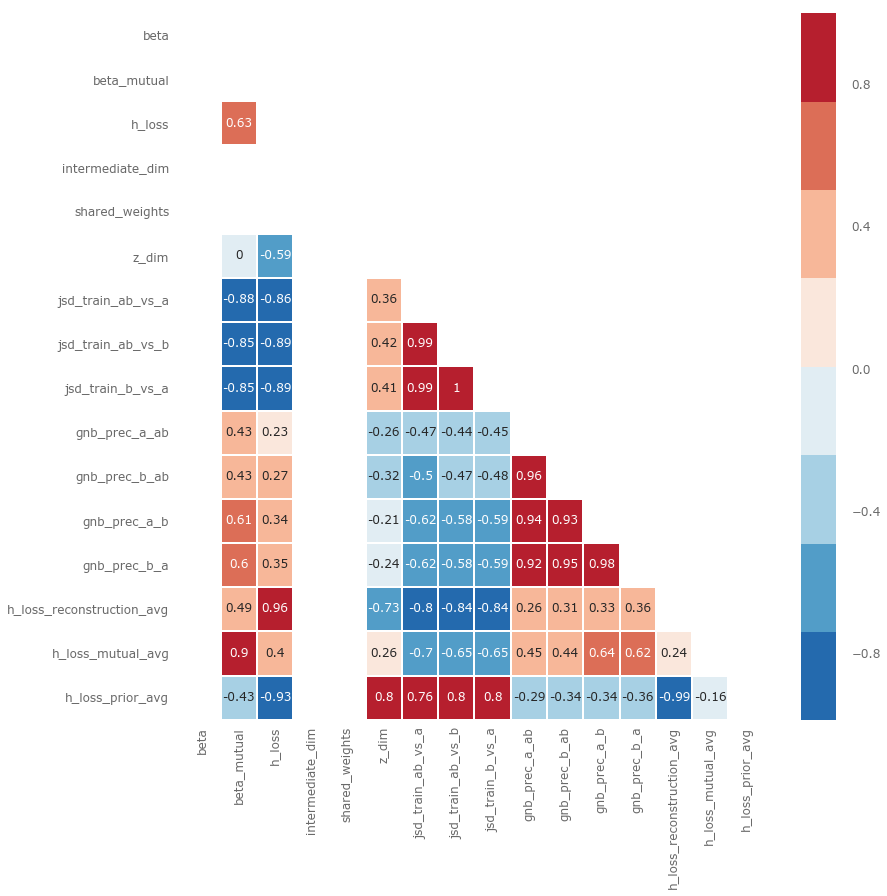

In [125]:
# concat
_df = pd.concat([df, df_jsd, df_gnb], axis =1) # .reset_index()


# make beta-mutual linear
#_df['beta_mutual'] = _df['beta_mutual'].apply(lambda x: int(np.log10(x)))
#_df = _df[_df['beta_mutual'] != int(1)]

# correlation w/o validation
_df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index","seed","epochs","batch_size"], axis=1)
_df = _df.drop(["gnb_prec_a_a", "gnb_prec_ab_ab", "gnb_prec_b_b", "gnb_prec_ab_a", "gnb_prec_ab_b"], axis=1)
_df = _df.drop(["jsd_train_ab_vs_ab"], axis=1)
_df = _df.drop(["lr"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]
_df = _df[[c for c in _df.columns if c[:8] != 'jsd_test']]

# mean of reconstruction losses
__df = _df[[c for c in _df.columns if c[:21] == 'h_loss_reconstruction']]
_df = _df[[c for c in _df.columns if c[:21] != 'h_loss_reconstruction']]
_df['h_loss_reconstruction_avg'] = __df.mean(axis=1)

# mean of mutual losses
__df = _df[[c for c in _df.columns if c[:13] == 'h_loss_mutual']]
_df = _df[[c for c in _df.columns if c[:13] != 'h_loss_mutual']]
_df['h_loss_mutual_avg'] = __df.mean(axis=1)

# mean of prior losses
__df = _df[[c for c in _df.columns if c[:12] == 'h_loss_prior']]
_df = _df[[c for c in _df.columns if c[:12] != 'h_loss_prior']]
_df['h_loss_prior_avg'] = __df.mean(axis=1)

astetik.corr(_df, color_grades=5, style='astetik', annot=True)
#_df

In [126]:
_df = pd.concat([df, df_jsd, df_gnb], axis =1) #

#df

_df1 = _df[_df['beta_mutual'] == int(1)]
#_df1[['h_loss', 'jsd_test_ab_vs_b']]

In [127]:
_df_1 = _df[_df['beta_mutual'] == int(-1)]
#_df_1[['h_loss', 'jsd_test_ab_vs_b']]


In [128]:
def plot_loss_surface(loss_str = '', hp_str = [''], df = None, axs = None, ngridx = 100, ngridy = 200, vmin=0., vmax=1., norm=None):
    import itertools
    import matplotlib.tri as tri
    #  Plot surfaces in one row
    df_loss = df[[loss_str] + hp_str]
    #df_loss = _df[['h_loss', 'beta_mutual']]
    #_df[_df['beta_mutual'] == int(1)]

    hp_str_pairs = list(itertools.combinations(hp_str, 2))

    print(hp_str_pairs)

    cs = []

    _vmin, _vmax = df_loss[loss_str].values.min(), df_loss[loss_str].values.max()
    for pair, ax in zip(hp_str_pairs, axs):

        z = df_loss[loss_str].values
        x = df_loss[pair[0]].values
        y = df_loss[pair[1]].values

        # Create grid values first.
        xi = np.linspace(x.min(), x.max(), ngridx)
        yi = np.linspace(y.min(), y.max(), ngridy)
        triang = tri.Triangulation(x, y)
        interpolator = tri.LinearTriInterpolator(triang, z)
        Xi, Yi = np.meshgrid(xi, yi)
        zi = interpolator(Xi, Yi)

        #from matplotlib import cm
        #from matplotlib.colors import ListedColormap, LinearSegmentedColormap
        #viridis = cm.get_cmap('viridis', 256)

        #
        #newcolors = viridis(np.linspace(0., 1., 256))
        #newcmp = ListedColormap(newcolors)

        cs.append(ax.pcolor(Xi,Yi,zi, vmin=vmin, vmax=vmax, norm=norm))

        #cs[-1].set_clim(vmin=vmin, vmax=vmax)
        ax.set_ylabel(pair[1])
        ax.set_xlabel(pair[0])

    return cs

In [129]:
# Prepare the data frame
df_plt = _df.copy()
df_plt['latent_intermediate_dim'].replace([None], 0, inplace=True)
df_plt['beta_mutual'] = df_plt['beta_mutual'].apply(lambda x: np.log10(x))

In [130]:
x, y, Z = df['beta_mutual'].values, df['latent_intermediate_dim'].values, df['h_loss'].values
x = x[np.newaxis, :]
y = y[:, np.newaxis]

In [131]:
import plotly.express as px
fig = px.parallel_coordinates(df_plt, color="jsd_test_ab_vs_a",
                              dimensions=['latent_intermediate_dim', 'z_dim', 'beta_mutual'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()


In [132]:

fig = px.parallel_coordinates(df_plt, color="z_dim",
                              dimensions=['h_loss', 'jsd_test_ab_vs_a', 'h_loss_mutual_0', 'h_loss_mutual_1'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=50)
fig.show()

In [133]:
fig = px.parallel_coordinates(df_plt, color="latent_intermediate_dim",
                              dimensions=['h_loss', 'jsd_test_ab_vs_a', 'h_loss_mutual_0', 'h_loss_mutual_1'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [134]:
fig = px.parallel_coordinates(df_plt, color="beta_mutual",
                              dimensions=['seed', 'h_loss', 'h_loss_mutual_0', 'h_loss_mutual_1', 'gnb_prec_ab_a', 'jsd_test_ab_vs_a'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [135]:
tmp = df_plt['gnb_prec_ab_a']
print(tmp.mean(axis=0))
print(tmp.std(axis=0))

0.7708420408163267
0.10103597226997577


In [136]:
fig = px.parallel_coordinates(df_plt, color="beta_mutual",
                              dimensions=["beta_mutual", 'z_dim', 'latent_intermediate_dim', 'gnb_prec_ab_a', 'jsd_test_ab_vs_a'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              width=1920/2, height=1080/2)
fig.show()


# End of File